---

# Welcome !!!

- Original work @chryzal [notebook](https://www.kaggle.com/chryzal/jigsaw-ensemble-0-864)

- Method inspired by @kyakovlev [notebook](https://www.kaggle.com/kyakovlev/m5-dark-magic)

After @kyakovlev's work, I wondered how this scaling method can be so competitive.
I thought about applying this method (which I don't recommend) on this competition, to see the result it will give. 

After several tests (in a private notebook) I thought to share the result of this work, to better understand how this phenomenon is possible.

So, welcome to this discussion!

### Please, *Do* Upvote if you copy this notebook

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [2]:
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
print(df.shape)

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
102128,"60 years \n\nit says haywirs prison sentence is for 60 years, i know this is true but how old was he when he went to prison, how old when he killed his parents?",1
21742,"Better late then ever. \n\nGood riddance, militant freak.",1
69107,Fuck you 2.0 \n\nYou are an idiot and an admin abuser.\nI will keep coming back until my edits stay!,1
112336,Watch your mouth \n\nHow dare you call me a troll? You ugly piece of shit.86.148.20.38,1
144734,"Hello,sorry to waste you're time \n\nhello, sorry to waste your time.I'm sure you are very busy,but you are a faggot?",1
78303,Bitch ass nigger \n\nWhy did you edit my article? You added referances and I never gave you permissian to touch it! Fucking bitch!,1
66389,Niggus luv dem wyt biches \nfa reel,1
128429,What is wrong with you? Are you a racist or something?,1
55082,Unblock\nCan you unlock my talk page or are you gonna be a dick about it?,1
56310,"Your a twat, you just delete things that you dont have a clue about! Che Finlay Will orientate your ass!! He'l find you!!",1


****** severe_toxic *******


,comment_text,severe_toxic
69498,You biased...You mongrol swine..dickk sukker head..you farshists ass likker.. \n\nI give u proof that dhoni is a rajput\nchk it\nhttp://my.opera.com/AaryanRajput/blog/.\nYou mother fucker you bastard u biased ronchos...the bastard gujjar suppporter..\nI am a badgujjar and i am a rajput..why are ...,1
43922,fuck off you monkey cock sucker,1
102165,fuck you.\n\nyour fuckin stupid and i'm black and fuck you\nfuck uou\nsdjasf;ldjgs\ndgsdg;lknfdts,1
26947,Good riddance you fucking asshole!! Bog off forever.,1
74272,"PERSIAN? GODDAMN MUSLIM TERRORIST? I HOPE YOU GET NUKED, SLUT",1
66061,TWAT \n\nyour a fucking twat mosh u fucking little batty boy wots ur mother fucking prblem,1
69322,"I wrote that shit ages ago, what are you a slaking faggot",1
60951,okay okay okay first off FUCK YOU.\n\nSECOND SECOND SECPOND HOLD ON PLZ DONT PERMA BAN ME. plz plz plz my mom'll make me take out the trash then!\n\nalso do u hav a lyf?,1
37497,wikipedia loves cock \n\nwikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves cock wikipedia loves coc...,1
137811,they are retarded niggers,1


****** obscene *******


,comment_text,obscene
131584,masturbation|jerk off]] your penis,1
50187,tide rolls is a fucking moron he needs to go to HELL,1
31515,Yes there are problems with your English you pathetic Mexican asshole - I'm gonna continue making your life hell until I can rejoice in the pleasure of hearing your death.,1
55232,"Wow, how stupid are you guys? Speaking of selfish people Hybridlily, isn't changing the picture to someone that you personally perfer considered selfish, last time I checked it was.\n\nAnother thing I just discovered is that you can't read. Where does this article fucking say taht ALL Turks are ...",1
18154,"Up yours you fucking fruit. InShaneee what kind of name is that anyway, for a cat?",1
117161,Dear DoorsAjar - Please tell BongWarrior that the vandals have won. BongWarrior has had to protect is Talk page because vandals kept on writing about what a cock loving faggot he is. Bitch.,1
105919,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",1
133281,hahahahahahahahahahahahahaha \n\nyour signature is BullShit hahahahahahahahahahahahahahahaha,1
156396,Is a one times massive cunt,1
115766,IM GOING TO KILL YOU\nYOU ARE WORTHLESS IM AM GOING TO KILL YOU AND BURN YOUR HOUSE DOWN BUT NOT BEFOR I HACK YOU LILLTE ACCOUNT AND TAKE YOUR LIVELIHOOD AWAY,1


****** threat *******


,comment_text,threat
147725,"That may be the case, but there is still no ambiguity over the repulsiveness of irish nationalists, who deserved to be shot dead. 79.75.141.101",1
157631,I Want You \n\nI wanna rape you good. I want your sexy body and sexually abuse you!,1
159029,Death to Musulmans!,1
123959,He is very arrogant unfortunately - I'm hoping to stab him to death soon.,1
23374,hey!!!!!!! thank you for re-editing my contributions it was really kind of you!!!!!!! i hope you get bowel cancer,1
100274,"Firśt, I aṃ ģoinģ ţo ţie ŷou uṗ and keeṗ ŷou çonśçiouś durinģ ţhe folloŵinģ ṗroçeśś ţhrough ţhe uśe of aṃṃonia. Nexţ, I ŵill ṃuţilaţe ŷour ģeniţalś and forçe ŷou ţo eaţ ţheṃ. Then I ŵill çuţ off biţś of ŷour śkin and ṃake a ģlove ouţ of ţhe śkin from ŷour hand. I ŵill ţhen çuţ oṗen ŷour ģuţ and ...",1
56310,"Your a twat, you just delete things that you dont have a clue about! Che Finlay Will orientate your ass!! He'l find you!!",1
41985,Reasons why I hate you \n\n1. You wrote on my page. Die. Die now bastard.\n\n2. Being annoyingly quick at editing. You are gay.\n\n3. Anally savaging my pets.,1
13886,"You're welcome and I'm gonna vandalize every single page on the Wikipedia. Hopefully you will enjoy my stay and for the future, I'm gonna find out where you live and I'm gonna kickin your ass and the ass of your family! So watch out you nigger! Heil Hitler!",1
44734,Hi mutherfuckng wikipedia nolifer go die pl0x. \nWith vänlig hälsning VOP,1


****** insult *******


,comment_text,insult
133935,"Dick cheese sounds more fitting for you!!! I don't waste my time with games, you crazy Canuck! Subwayjack",1
12464,You're a motherfucking idiot\n\nYou're stupid as all hell and know *nothing*! Butt out of the business of your superiors!,1
128819,"Do you want to lose your sysop rights? I will help you, little idiot.",1
38748,"Buck Winston \n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you tell me\n\nFuck you, I won't do what you te...",1
157564,Fuck of \n\nYou fuck of...212.253.147.120,1
35453,. UR SUCH A FUCKING GEEK ASS MOFO! UR MOTHERS SUCKING MY COCK RIGHT NOW FAGETASS!!!!!!,1
69906,"It doesn't make any difference anyway Spartaz. Corrupt, rude and dishonest admins do what they want here anyway, just look at the sections above. But here was the start of our discussion which, despite my polite request, quickly devolved into assumptions of bad faith on your part and extraordin...",1
98024,"""\n\n Everlast \n\nSarek, if you actually read some of the things """"Stan"""" wrote and read his talk page, I think you would see who is warring with who. Did you notice that someone else a while back warned him about vandalizing Everlast's site? Did you notice he called that guy a Scumbag? I shoul...",1
134222,"Don't worry about this TheJPS broad... she is a total numbskull. TheJPS is an extreme left wing editor that uses Wikipedia to bully people with different political beliefs than her own. Also, TheJPS has a small group of left-wing extremist administrators that have all NOMINATED each other and ju...",1
66741,==ChrisO Internet Vandal and Criminal==\nChrisO belonge to international Homo criminal organization see more at www.ChrisO.homo.com\nChrisO is an fucken idiot with chicken brain ha ha ha....,1


****** identity_hate *******


,comment_text,identity_hate
4159,"LOL; charles, you are a real fag aren't you? siding with chinks?? \ngo fuck yourself, asswipe! we don't need no chinks in here. \n\nFAG",1
131722,"LWC, there is more to it than you think. You see one particular editor here, Ctjf83, pus out all possible stops to retain this image, even over other fisting images. Hmmmmm. This is because it is quite transparent that it is a photo of himself getting fisted, and he gets some satisfaction from...",1
146880,"I have been blocked because this white guy couldnt handle the fact that his little white baby dick wasnt good enuff 4 me. I am just stating the facts, i mean thats what this is an encyclopedia.... I have been around, seen alot of different guys dicks, im talken hundreds, the fact is nigga Gs dic...",1
73124,Listen to me nigga I am your Lord ! Go to cotton plantation and work for Proud South!,1
89637,ONOREM IS A NAZI FAGGOT,1
106617,", I hope your retarded kids get anal raped and murdered for having such a fag as a father. I'm gonna fuck your fat wife and trow her over the bridge. Consider yourself happy, another useful editor of Wikiepia retired. I see more users retired everyday. Don't even dare removing this you peace of ...",1
101314,Stupid Asian Bitch \n\nYou're an idiot and you should go back to ching chong land,1
141374,"Fuck you all, antisemitic faggots. 128.69.234.194",1
12241,"RE:Knowledge Generation Bureau \n\nWhy the fuck are you gay? what kinda faggot deletes information, regardless of how useful it is? I think people like you should be analy raped by satan's thorny cock for all eternity for trying to keep the masses ignorant, you elitest piece of shit. Trying to k...",1
70535,Fuck you fuckin ball bag bitch,1


In [3]:

# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
154331,Ur edits are really good,0.0
54355,deleted entry \n\nHi Kurykh- I'm a reporter with the Allentown Morning Call hoping to interview you for a story about a deleted Wikipedia entry. Can I e-mail you somewhere so we can correspond today? Thanks.,0.0
152365,"""\n\n User:Carolljon \n\nWell, I advice to remove those talk messages all by yourself. I've been pretty decent with you. Your usage of the f-word was unwarranted. I'm not even insisting on an apology. Be good and I'll be good to you. Otherwise get ready to bear the consequences.-My coffee shop """,0.0
24958,"I am very sorry. Sometimes, using STiki, the tool combines edits. This happened, you got slapped with a warning meant for another user who was being disruptive. Your edits were fine.",0.0
77945,", 20 November 2010 (UTC)\n\nThis user: User talk:93.97.59.17 86.181.1.250 16:03",0.0


In [4]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [5]:
n_folds = 7

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
Fold: 1
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
Fold: 2
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
Fold: 3
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
Fold: 4
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
Fold: 5
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429   

# Create 3 versions of __clean__ data

In [6]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):
    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

In [7]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [8]:
df = clean(df,'text')

In [9]:
df[df.y==0]

,text,y
0,"Explanation Why edits made username Hardcore Metallica Fan reverted ? They vandalisms, closure GAs I voted New York Dolls FAC. And please remove template talk page since I ' retired now.89.205.38.27",0.0
1,"D ' aww ! He matches background colour I ' seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I ' really trying edit war. It guy constantly removing relevant information talking edits instead talk page. He seems care formatting actual info.",0.0
3,""" More I cannot make real suggestions improvement - I wondered section statistics later on, subsection """"types accidents"""" -I think references may need tidying exact format ie date format etc. I later on, no-one else first - preferences formatting style references want please let know. There app...",0.0
4,"You, sir, hero. Any chance remember page ?",0.0
...,...,...
159566,""":::::And second time asking, view completely contradicts coverage reliable sources, anyone care feel ? You cannot even give consistent argument - opening supposed mention significant aspects, """"most significant"""" ones ? """,0.0
159567,You ashamed That horrible thing put talk page. 128.61.19.93,0.0
159568,"Spitzer Umm, theres actual article prostitution ring. - Crunch Captain.",0.0
159569,And looks like actually put speedy first version deleted I look it.,0.0


In [10]:
n_folds = 7

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429     265
0.857143     109
1.000000       8
Name: y,

In [11]:
del df,tmp_df
gc.collect()

42

## Ruddit data

(5838, 5)


<AxesSubplot:>

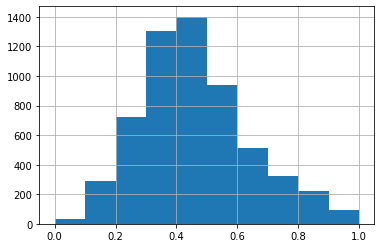

In [12]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

# Create 3 versions of data

In [13]:
n_folds = 7

frac_1 = 0.7

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [14]:
del tmp_df, df_; 
gc.collect()

42

## Load Validation and Test data  


In [15]:
# Validation data 

df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

In [16]:
# Test data

df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

In [17]:
# NOT USED 
class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

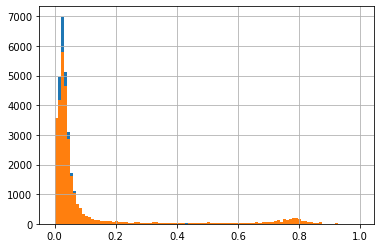

In [18]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [19]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

### Toxic data

In [20]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 80874
[('vect3__uck', 0.43),
 ('vect3__fuc', 0.36),
 ('vect3__fuck', 0.32),
 ('vect3__you ', 0.32),
 ('vect3__ ass', 0.31),
 ('vect3__ass', 0.3),
 ('vect3__shit', 0.3),
 ('vect3__ you ', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__ nl', 0.26),
 ('vect3__ f ', 0.25),
 ('vect3__ rape', 0.25),
 ('vect3__nl3', 0.25),
 ('vect3__ g ', 0.24),
 ('vect3__ u ', 0.24),
 ('vect3__bitch', 0.24),
 ('vect3__fag', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__ fag', 0.23),
 ('vect3__ gay', 0.23),
 ('vect3__nigg', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__bitc', 0.22),
 ('vect3__suck', 0.22),
 ('vect3__uck ', 0.22),
 ('vect3__wwwww', 0.22),
 ('vect3__ rap', 0.21),
 ('vect3__!!!', 0.21)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features

# Toxic __clean__ data

In [21]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 75032
[('vect3__uck', 0.39),
 ('vect3__ f ', 0.36),
 ('vect3__fuc', 0.32),
 ('vect3__fuck', 0.31),
 ('vect3__shit', 0.31),
 ('vect3__ ass', 0.28),
 ('vect3__ass', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ rape', 0.27),
 ('vect3__ fu', 0.26),
 ('vect3__ nl', 0.26),
 ('vect3__nl3', 0.26),
 ('vect3__ g ', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__bitch', 0.23),
 ('vect3__fag', 0.23),
 ('vect3__suck', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ gay', 0.22),
 ('vect3__ rap', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__rape ', 0.22),
 ('vect3__ fag', 0.21),
 ('vect3__ fuck', 0.21),
 ('vect3__bitc', 0.21),
 ('vect3__nigg', 0.21),
 ('vect3__ * ', 0.2),
 ('vect3__ as', 0.2),
 ('vect3__ nig', 0.2),
 ('vect3__ie ', 0.2)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features: 7

## Ruddit data pipeline

In [22]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )
    print("\nTrain:")
    
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features:

In [23]:
del df, pipeline, feature_wts
gc.collect()

429

In [24]:

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data 
Validation Accuracy is 67.47


In [25]:

print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data new 
Validation Accuracy is 67.47


# Validate the pipeline 

In [26]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')


 Toxic data 
Validation Accuracy is 68.17
 Ruddit data 
Validation Accuracy is 62.56
 Toxic CLEAN data 
Validation Accuracy is 67.47


In [27]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( (w1,w2,w3, 
                         np.round((p1_wt < p2_wt).mean() * 100,2))
                      )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.61, 0.29, 0.10000000000000003, 68.61),
 (0.66, 0.17, 0.16999999999999996, 68.61),
 (0.6, 0.29, 0.11000000000000004, 68.6),
 (0.6, 0.24, 0.16000000000000003, 68.6),
 (0.61, 0.28, 0.10999999999999999, 68.6)]

In [28]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6


## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [29]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)

df_val['correct'] = (p1_wt < p2_wt).astype('int')


In [30]:

### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
28592,0,"""\nThese links have not been discussed and they should. If they're not included on this page then it should be removed completely as Justin Berry will likely want only his POV or those that parrot it. It should also be noted that neither of these sites are """"pro-pedophilia"""". In fact, the ver...","Bat ye'or is an authoritve source ,at least she comperhends logic unlike this Annemarie Schimmel, no wonder Spencer and so forth think that Academia is completely Biased. So its non-muslims fault they are slaves for not converting (and forceing muslims to take them as POW's) is going to WP stanc...",0.034364,0.037383,0.315804,0.315801,0.000004,0
28868,144,"Cubits, hogsheads, rods, chains, etc? \n\nSince we've got to have Imperial as well as Metric, maybe we should be adding all the above (and more)? Jimbo must be off his nut...","\n\nPlease respond, and not defensively, here. No sane person would look at what you do, day and night, day after day, week after week, month after month, year after year and not conclude that you need a massive intervention. I have to think you are a very lonely, unhappy person, so no one p...",0.028736,0.014684,0.266874,0.266832,0.000042,0
16822,215,"You're nothing but a fucking massive fag. You edit others pages without their permission, which makes you a fag. You are the satan child spawned from your mother who procreated with your god damn retarded uncle.",FUCK YOU \n\n70.17.2.2 Forever,0.014085,0.275862,0.593143,0.593073,0.000070,0
16040,154,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
16042,233,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
16041,409,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
22641,626,dog. Do I make myself clear you unthinking little urchin,"Vanilla Ice \n\nAlright I'm going to tone it down for this last one, I'm not going to bother trying to get that changed because because it's obvious you aren't going to change your latent racism and uber-capitalist view of music but I'm just saying for the record that numerous critics and music...",0.035714,0.028881,0.275287,0.275140,0.000147,0
10886,488,GIVE ME THE SOURCE THAT SAYS THAT_YOU ARE JUST GOING ON HUNCHES NOW AS EVIDENT WITH THE GRIMALDI FACT AS SOURCED PREVIOUSLY> YOU WILL BE REPORTED TO WIKIPEDIA> YOU ARE A BOGUS SHAM THAT IS MAKING UP YOUR OWN HISTORY,unblock me you prick \n\nyeah,0.797235,0.000000,0.320067,0.319878,0.000189,0
10885,400,GIVE ME THE SOURCE THAT SAYS THAT_YOU ARE JUST GOING ON HUNCHES NOW AS EVIDENT WITH THE GRIMALDI FACT AS SOURCED PREVIOUSLY> YOU WILL BE REPORTED TO WIKIPEDIA> YOU ARE A BOGUS SHAM THAT IS MAKING UP YOUR OWN HISTORY,unblock me you prick \n\nyeah,0.797235,0.000000,0.320067,0.319878,0.000189,0
14497,541,"Where to now?\nRegarding User talk:Kaiwhakahaere#You appear to have an imitator, please advise how I can air my suspicions with your threat to block me hanging over my head. Am I permitted to seek a checkuser or similar?","""\n\nwell then why not add something that says along the lines of """"becasue of the vagueness of the company, it is currently unknown what is ionized about this bracelet, thereby making it impossible to discredit this brace

#### Some of these just look incorrectly tagged 


In [31]:
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,1.170218,0.175494,0.994724,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.000000,0.039146,0.997270,0.256171,0.741099,0
29057,716,"Fuck You\n\nGo suck on a fat dick faggot mother fucker. I'm the the wrong person to fuck with you puck ass pussy! I would keep my moth shut, or I can shut for you!","""\n\nFUCCK U A$$HOLE do wateva u want DIICK HEAD Contact Blogsd ! """,0.036585,0.328358,1.116110,0.410984,0.705126,0
29056,204,"Fuck You\n\nGo suck on a fat dick faggot mother fucker. I'm the the wrong person to fuck with you puck ass pussy! I would keep my moth shut, or I can shut for you!","""\n\nFUCCK U A$$HOLE do wateva u want DIICK HEAD Contact Blogsd ! """,0.036585,0.328358,1.116110,0.410984,0.705126,0
19411,46,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",wow the guy who deleated the stuff on the Habbo NSM is leet. 88!,0.035714,0.062500,0.954310,0.250308,0.704001,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.023876,0.322405,0.701472,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.023876,0.322405,0.701472,0
21059,333,fuck you \n\nyou're an idiot,"What makes you an editor? Why do you use the name of a great dead man? What is your true name, profession, country? \nShamir",0.000000,0.032520,0.961349,0.272206,0.689142,0
17175,179,"Gon Be A Snitch \n\nYou are a little bitch. I fuckin spent 6 hours on big sam (rapper) an you call it fuckin vandolism, hard ass aint you, fuck you i'm makin a true ass page an you wack off an delete my page. What the fuck is up, your like a snitch but to yourself. I'll fuckin edit your bitch a...",INDIAN ANUS IS STRETCHED AND WIDENED BY GRAWP’S MASSIVE COCK.,0.037657,0.819672,1.015897,0.328891,0.687005,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",0.500000,0.015038,0.981509,0.295832,0.685677,0


# Predict on test data 

In [32]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [33]:
#test_preds_arr

## Correct the rank ordering

In [34]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

14

In [35]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.716583,3
1,0.516385,2
2,0.341199,2
3,0.330862,2
4,0.300962,2
5,0.319677,2
6,0.344709,2
7,0.176764,2
8,0.369158,2
9,0.292556,2


In [36]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.176764
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.176764
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
4758,270227418,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.344709
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.344709
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.369158
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.369158
5852,346641598,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS,0.300962


# Bert Ensemble

In [37]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 41,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 59/59 [00:29<00:00,  2.02it/s]


Getting predictions for model 2


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


Getting predictions for model 3


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


Getting predictions for model 4


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


Getting predictions for model 5


100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


CPU times: user 2min 34s, sys: 6.08 s, total: 2min 40s
Wall time: 3min 28s


In [38]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [39]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15

In [40]:
df_sub

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether there is an """"anti-editorializing"""" policy here. There is, and it's called wikipedia:neutral point of view. It discusses at some length the case of what we should do when writing about a subject which most of us find repugnant. Whilst you're not like...",0.241946
1,732895,"Looks like be have an abuser , can you please look into this? thanks.",0.186831
2,1139051,"I confess to having complete (and apparently blissful) ignorance of Jordan, but I've glanced at the article. Is this a woman or a soap opera!?. I don't think there was much to change in terms of the description of the various diseases. It is mentioned that she is famous for the size of her bre...",0.217368
3,1434512,"""\n\nFreud's ideas are certainly much discussed today, and I would be the first to agree that they must be grappled with and dealt with seriously, if only because of their currency. So Freud deserves a long and thorough article in Wikipedia. I believe that a balanced article would include A) e...",0.222786
4,2084821,It is not just you. This is a laundry list of stupid allegations scooped up from god-knows-where. Probably two-thirds of it has little basis in fact.,0.320759
...,...,...,...
7532,504235362,"Go away, you annoying vandal.",0.283036
7533,504235566,This user is a vandal.,0.180440
7534,504308177,""" \n\nSorry to sound like a pain, but one by following me here is a tad stalking in all honesty but I'm not too bothered about that. But the main worry is that you have just assumed badly that I was referring about you, when it is clear I wasn't. One should never jump to conclusions without ch...",0.262589
7535,504570375,Well it's pretty fucking irrelevant now I'm unblocked aint it! 81.108.7.13,0.408092


# Scaling methods

In [41]:
for i in range(0, 500):
    df_sub['score'][i] = df_sub['score'][i] * 1.23

In [42]:
for i in range(801, 1200):
    df_sub['score'][i] = df_sub['score'][i] * 1.34

In [43]:
for i in range(1701, 2300):
    df_sub['score'][i] = df_sub['score'][i] * 0.9

In [44]:
for i in range(2501, 2980):
    df_sub['score'][i] = df_sub['score'][i] * 0.9

In [45]:
for i in range(3001, 4000):
    df_sub['score'][i] = df_sub['score'][i] * 1.34

In [46]:
for i in range(4001, 4500):
    df_sub['score'][i] = df_sub['score'][i] * 1.35

In [47]:
for i in range(4501, 4940):
    df_sub['score'][i] = df_sub['score'][i] * 0.9

In [48]:
for i in range(5501, 5980):
    df_sub['score'][i] = df_sub['score'][i] * 0.89

In [49]:
for i in range(6001, 6500):
    df_sub['score'][i] = df_sub['score'][i] * 1.36

In [50]:
for i in range(6501, 6950):
    df_sub['score'][i] = df_sub['score'][i] * 0.92

In [51]:
for i in range(7001, 7536):
    df_sub['score'][i] = df_sub['score'][i] * 1.345

## Submission for kaggle

In [52]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

# Conclusion

We have just noticed that this method increases the scores (only for the regression tasks). 

But is it better to do so?

I think not, because this method does not take into account the overfitting.

And you, what do you think?

## Juste do UPVOTE
I would like to be a notebook Grandmaster too 😎